# 2019 Chapel Hill Expert Survey
## Exploratory analysis

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from urllib.request import urlretrieve
from pathlib import Path
from itertools import cycle
from typing import List, Optional
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from factor_analyzer import FactorAnalyzer

#### Data loading

In [3]:
# Code for data loading
data_url: str = "https://www.chesdata.eu/s/CHES2019V3.dta"
data_dir = Path("../data")
data_dir.mkdir(exist_ok=True)
data_path = data_dir / "CHES2019V3.dta"
ches_2019_data = pd.read_stata(data_path)

## Density distribution

#### Why?<br>
* **Discover Deeper Structures:** Explore how parties cluster along different ideological divides.<br>

* **Test Different Hypotheses:** What divides political parties. For example, is the divide over the EU the same as the divide over populism? Are views on immigration always linked to views on multiculturalism?<br>

#### What?<br>
* **Different Ideological Axes:** Each plot uses a different pair of variables from the dataset to define its two-dimensional space.<br>

* **Identifying clusters:** GMM algorithm finds four distinct ideological "families" based on that specific pair of issues.<br>

#### Analysis results
*NOTE: Following provides descriptions for selected variables*<br><br>
**1. Q1 - Economic vs. Social Ideology**<br>
* No single, unified ideological spectrum. The clusters are spread across the plot in a circular pattern.<br>

**2. Q2 - EU Stance vs. Populism**<br>
* clear divide between pro-EU, mainstream parties and populist parties."<br>

**3. Q3 - Immigration vs. Multiculturalism**<br>
* Stances on immigration policy and multiculturalism are extremely highly correlated. The clusters are arranged in a tight, diagonal line.<br>

**4. Q4 - State Intervention vs. Social Lifestyle**<br>
* No single, unified ideological spectrum. The clusters are spread across the plot in a circular pattern.<br>

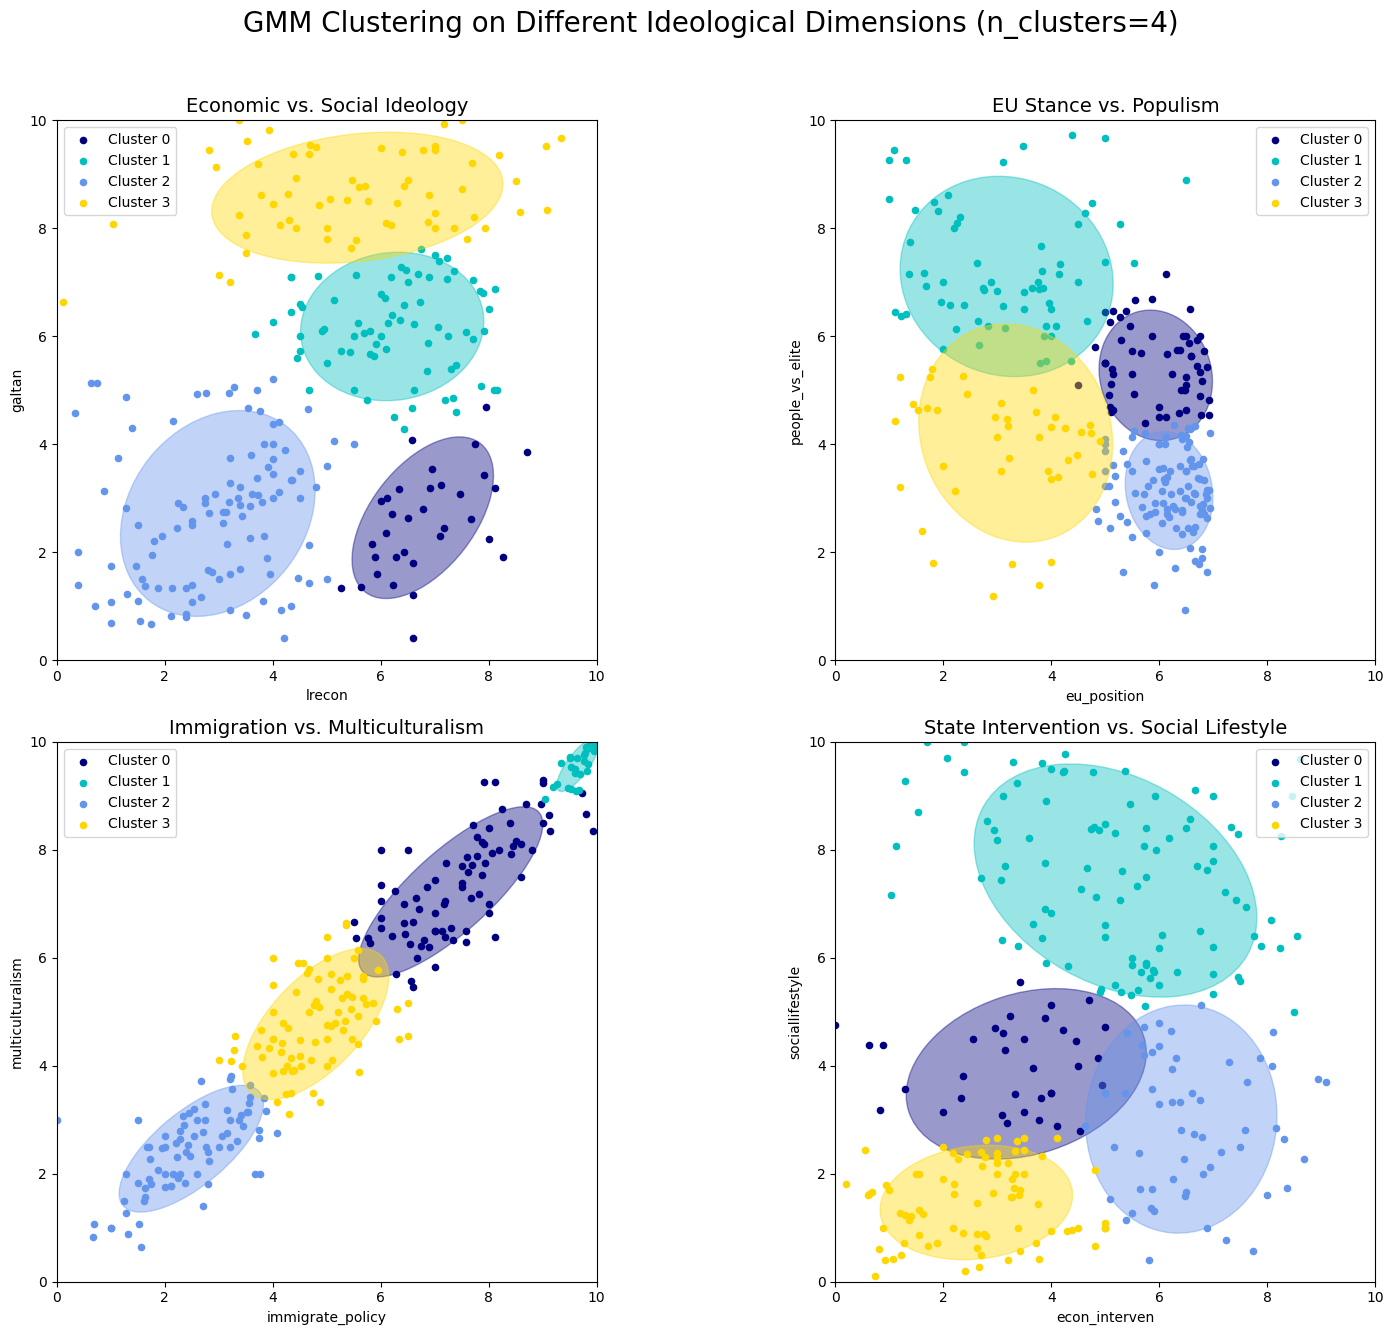

In [4]:
# Helper function to generate a 2D scatter plot.
def scatter_plot(
    transformed_data: pd.DataFrame,
    color: str = "y",
    size: float = 20.0,
    splot: plt.subplot = None,
    label: Optional[List[str]] = None,
):
    if splot is None:
        splot = plt.subplot()
    columns = transformed_data.columns
    splot.scatter(
        transformed_data.iloc[:, 0],
        transformed_data.iloc[:, 1],
        s=size,
        c=color,
        label=label,
    )
    splot.set_aspect("equal", "box")


# --- GMM Clustering Grid Logic ---

# 1. Define the variable pairs and titles for the 2x2 grid
plot_definitions = [
    {'vars': ['lrecon', 'galtan'], 'title': 'Economic vs. Social Ideology'},
    {'vars': ['eu_position', 'people_vs_elite'], 'title': 'EU Stance vs. Populism'},
    {'vars': ['immigrate_policy', 'multiculturalism'], 'title': 'Immigration vs. Multiculturalism'},
    {'vars': ['econ_interven', 'sociallifestyle'], 'title': 'State Intervention vs. Social Lifestyle'}
]

# 2. Create the 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('GMM Clustering on Different Ideological Dimensions (n_clusters=4)', fontsize=20)
axes = axes.flatten() # Flatten the 2x2 array for easy iteration

# 3. Loop through each definition and create a plot
for i, p_def in enumerate(plot_definitions):
    ax = axes[i]
    
    # a. Prepare the data
    X = ches_2019_data[p_def['vars']].copy().dropna() # Drop rows with missing values for this pair
    
    # b. Fit a Gaussian Mixture Model
    n_clusters = 4
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0).fit(X)
    means = gmm.means_
    covariances = gmm.covariances_
    Y_ = gmm.predict(X)
    
    # c. Run the plotting logic
    color_iter = cycle(["navy", "c", "cornflowerblue", "gold", "darkorange", "g"])

    for j, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        
        # Filter data for the current cluster
        cluster_data = X[Y_ == j]
        if cluster_data.empty:
            continue
        
        # Use the scatter_plot function to plot the points
        scatter_plot(cluster_data, color=color, splot=ax, label=f'Cluster {j}')

        # Plot the ellipse
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.4)
        ax.add_artist(ell)
    
    # d. Standardize axis limits and labels
    ax.set_xlabel(p_def['vars'][0])
    ax.set_ylabel(p_def['vars'][1])
    ax.set_title(p_def['title'], fontsize=14)
    ax.set_xlim(0, 10) # Set X axis limit
    ax.set_ylim(0, 10) # Set Y axis limit
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


## T-test

#### Why?<br>
* **Test a Specific Hypothesis:** To find - Are the core values and policy positions of political parties in Western Europe systematically different from those in Eastern Europe?.<br>

* **Identify Key Divides:** Pinpoint which specific ideological dimensions (like social values or immigration) are the true fault lines between the regions.

#### What?<br>
* **T-Test:** Comparing the means of a chosen variable between two distinct groups.

* **P-Test:** probability of seeing a difference as large as the one observed if there were no real difference between the groups. A small p-value (less than 0.05) allows us to reject the "no difference" hypothesis and conclude that the divide is statistically significant..

#### Analysis results
*NOTE: Following provides descriptions for selected variables*<br><br>
**1. Social Values (GAL/TAN) - <span style="color:red">MAJOR DIVIDE EXISTS</span>**<br>
* Western European parties are, on average, significantly more socially liberal (Green/Alternative/Libertarian), while Eastern European parties lean more towards Traditional, Authoritarian, and Nationalist values.<br>

**2. Economic Position (Left/Right) - <span style="color:green">NO SIGNIFICANT DIFFERENCE</span>**<br>
* No statistically significant difference between Western and Eastern European parties on these three key dimensions."<br>

**3. Economic Position (Left/Right) - <span style="color:green">NO SIGNIFICANT DIFFERENCE</span>**<br>
* No statistically significant difference between Western and Eastern European parties on these three key dimensions.<br>

**4. Populism (People vs. Elite) - <span style="color:green">NO SIGNIFICANT DIFFERENCE</span>**<br>
* No statistically significant difference between Western and Eastern European parties on these three key dimensions.<br>

**5. Immigration Policy - <span style="color:red">MAJOR DIVIDE EXISTS</span>**<br>
* Eastern European parties favor significantly more restrictive immigration policies compared to their Western counterparts.<br>

**6. Nationalism vs. Cosmopolitanism - <span style="color:green">NO SIGNIFICANT DIFFERENCE</span>**<br>
* No statistically significant difference between Western and Eastern European parties on these three key dimensions.<br>

In [5]:
# Import the necessary library for statistical tests
import scipy.stats as stats
import pandas as pd

# --- T-Tests: Comparing Multiple Ideological Dimensions between West and East ---

# 1. Define the groups
#    According to the CHES 2019 codebook, 1 = West, 0 = East
west_parties = ches_2019_data[ches_2019_data['eastwest'] == 1]
east_parties = ches_2019_data[ches_2019_data['eastwest'] == 0]

# 2. List the variables we want to test with user-friendly labels
variables_to_test = {
    'galtan': 'Social Values (GAL/TAN)',
    'lrecon': 'Economic Position (Left/Right)',
    'eu_position': 'Position on EU Integration',
    'people_vs_elite': 'Populism (People vs. Elite)',
    'immigrate_policy': 'Immigration Policy',
    'nationalism': 'Nationalism vs. Cosmopolitanism'
}

# 3. Create a DataFrame to store the results
results = []

# 4. Loop through each variable, perform the t-test, and store the results
for var, label in variables_to_test.items():
    # Select the data for each group and drop missing values
    group1 = west_parties[var].dropna()
    group2 = east_parties[var].dropna()
    
    # Perform the independent samples t-test. 
    # We use equal_var=False to perform Welch's t-test, which doesn't assume equal variance.
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False) 
    
    # Store results
    results.append({
        'Variable': label,
        'T-statistic': t_stat,
        'P-value': p_value,
        'Significant (p < 0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

# 5. Display the results in a clean table
results_df = pd.DataFrame(results)
print("--- T-Test Results: West vs. East European Parties ---")
print(results_df.to_string(index=False))


--- T-Test Results: West vs. East European Parties ---
                       Variable  T-statistic  P-value Significant (p < 0.05)
        Social Values (GAL/TAN)    -2.830111 0.005083                    Yes
 Economic Position (Left/Right)    -1.357327 0.175926                     No
     Position on EU Integration    -1.877918 0.061627                     No
    Populism (People vs. Elite)     0.296084 0.767428                     No
             Immigration Policy    -3.342768 0.000963                    Yes
Nationalism vs. Cosmopolitanism    -1.788109 0.075152                     No


## Factor analysis

#### Why?<br>
* **Finding Hidden Structures:** Identifies the underlying "mega-themes" or dimensions that are not explicitly measured but are driving the patterns in data.<br>

* **Reducing Redundancy:** Instead of tracking 12 different variables, now can focus on the three core dimensions.

#### What?<br>
* **Diamention reduction:** This analysis shows that the 12 selected variables can be effectively grouped into three distinct and independent factors.

#### Analysis results
*NOTE: Following provides descriptions for selected variables*<br><br>
**1. Factor 1 - Socio-Cultural Divide**<br>
* Parties having high loading for nationalism and multiculturalism are part of the cluster. As per the high loading variables, this factor defines Socio-Cultural Divid.<br>

**2. Factor 2 - Economic Divide**<br>
* Parties having high loading for deregulation and econ_interven are part of the cluster. As per the high loading variables, this factor defines Economic Divide."<br>

**3. Factor 3 - Governance Divide**<br>
* Parties having high loading for people_vs_elite and corrupt_salience are part of the cluster. As per the high loading variables, this factor defines Governance Divide.<br>

In [6]:
# --- Factor Analysis: Identifying Latent Ideological Dimensions ---

# 1. Select the variables for the analysis
#    These variables cover a range of economic, social, and governance issues.
variables_for_fa = [
    'eu_position', 'lrecon', 'galtan', 'immigrate_policy', 'multiculturalism', 
    'environment', 'econ_interven', 'redistribution', 'deregulation', 
    'nationalism', 'people_vs_elite', 'corrupt_salience'
]
X_fa = ches_2019_data[variables_for_fa].copy()

# 2. Handle missing data by dropping rows with any NAs in our selected columns
X_fa.dropna(inplace=True)

# 3. Create and fit the Factor Analysis model
#    We are hypothesizing that there might be 3 underlying factors (e.g., Economic, Social, EU/Governance).
#    You can experiment with changing n_factors.
fa = FactorAnalyzer(n_factors=3, rotation='varimax', method='principal')
fa.fit(X_fa)

# 4. Get the factor loadings
#    Loadings show how much each variable is correlated with each factor.
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, index=X_fa.columns, columns=['Factor 1', 'Factor 2', 'Factor 3'])

# 5. Display the loadings table, highlighting strong correlations
print("--- Factor Loadings ---")
print("Loadings represent the correlation of each variable with the factor.")
print("High absolute values (> 0.5) indicate a strong association.")
display(loadings_df.style.applymap(lambda x: 'background-color: #1758ec' if abs(x) > 0.5 else ''))


--- Factor Loadings ---
Loadings represent the correlation of each variable with the factor.
High absolute values (> 0.5) indicate a strong association.


,Factor 1,Factor 2,Factor 3
eu_position,-0.757013,0.351062,-0.101233
lrecon,0.264857,0.935139,-0.072059
galtan,0.899203,0.223109,0.010139
immigrate_policy,0.879962,0.355867,0.060081
multiculturalism,0.900059,0.337368,0.040346
environment,0.771621,0.451131,-0.127920
econ_interven,0.120807,0.957196,-0.035920
redistribution,0.277872,0.918172,-0.099693
deregulation,0.166217,0.954882,-0.103834
nationalism,0.949074,0.159219,0.023896
